# 第4週：對ptt上的魷魚遊戲議題進行情緒分析
**Author:** 林建玄 N094220004<br>
**Date created:** 2021/10/21<br>
**Last modified:** 2021/10/21<br>
本報告是基於助教提供的程式碼「情緒分析1」做為基礎，再由「中山管院文字分析平台」的爬蟲抓取相關 PTT 文章，其中加入特殊停用詞「遊戲」的處理，因為不處理這個正面詞「遊戲」，會造成正反面情緒失準，另外還有發現跟主題本身不相關的字詞，對其進行分析。

## 大綱
+ 1. 套件說明
+ 2. 資料前處理
    + 2.1 基本資料介紹
    + 2.2 資料清理
    + 2.3 文章斷詞
    + 2.3.1 特殊停用詞「遊戲」
+ 3. lexicon-base 情緒分析
    + 3.1 準備LIWC情緒字典
    + 3.2 情緒字典與斷詞結果進行合併
    + 3.3 正負向情緒分數聲量折線圖
    + 3.4 正負向情緒分數比例折線圖
    + 3.5 文字雲
    + 3.6 情緒代表字
    + 3.7 歸類正負面文章
    + 3.8 情緒關鍵字
    + 3.9 解讀有興趣的關鍵字

## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- numpy: 為科學運算所提供的套件。提供許多數學公式的實作以及高效率的陣列、矩陣運算。
- NLTK: 全名為Natural Language Tool Kit，自然語言處理工具。
- jieba: 中文斷詞套件。
- re: 正規表達式套件。
- datetime: 時間處理工具。
- wordcloud: 文字雲繪圖工具。
- matplotlib: 繪圖工具。

In [504]:
# 安裝會使用到的套件
!pip install wordcloud

In [505]:
from google.colab import drive
drive.mount('/content/drive')
# 確認當前目錄
%pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content'

In [506]:
from os import path
project_path = "/content/drive/MyDrive/NLP/group_7_first"

print(project_path)

/content/drive/MyDrive/NLP/group_7_first


In [507]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import re
import jieba
import jieba.analyse
from datetime import datetime
from wordcloud import WordCloud 

In [508]:
from matplotlib.font_manager import FontProperties
font_prop = FontProperties(fname=path.join(project_path, 'SourceHanSansTW-Regular.otf'), size=14)
# plt.xlabel("x軸", fontproperties=font_prop)

plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

## 2. 資料前處理
從網路或api取得的原始資料可能包含雜訊（多餘的空白、html標籤、網址等），在進行斷詞處理前應先進行資料清理。

### 2.1 基本資料介紹
- 資料來源: 文字平台收集PTT Gossip版2021-09-01 ~ 2021-11-01 所有文章
- 資料集： `raw_data/ptt_articleMetaData.csv`
- 關鍵字：魷魚遊戲
- 資料時間：2021-09-01 ~ 2021-11-01 

主要分析ptt上網友的相關討論，本次主要針對以下方向分析：
1. 魷魚遊戲的討論大概出現在哪個時間點，話題高峰在哪裡？
2. 正面和負面的討論內容各是甚麼，有沒有時間點上的差異？
3. 正面和負面討論的情緒分數大約多少？
4. 特殊的高頻詞為什麼會出現？

In [509]:
path.join(project_path,'raw_data/ptt_articleMetaData.csv')

'/content/drive/MyDrive/NLP/group_7_first/raw_data/ptt_articleMetaData.csv'

In [510]:
#匯入資料
MetaData = pd.read_csv(path.join(project_path, 'raw_data/ptt_articleMetaData.csv'), encoding='UTF-8')
Reviews = pd.read_csv(path.join(project_path, 'raw_data/ptt_articleReviews.csv'), encoding='UTF-8')

In [511]:
print(f"共有 {MetaData.shape[0]} 篇文章") #(row,column)
MetaData.head(3)

共有 941 篇文章


,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
0,[問卦]魷魚遊戲的老頭居然是主辦方之一?,2021/09/17,13:13:43,https://www.ptt.cc/bbs/Gossiping/M.1631884426.A.ED3.html,lovesaber,Gossiping,20,1,16,最後就剩李政宰獲勝\n\n其餘全部死光\n\n爽拿所有獎金\n\n然後一開始有腦癌的老頭居然是主辦方之一\n\n因為待在觀眾席太無聊 就跑下去玩了\n\n而裡面臥底的鴿子在找哥哥\n\n哥哥居然是黑面具
1,[問卦]韓國為什麼拍得出魷魚遊戲？,2021/09/18,17:27:22,https://www.ptt.cc/bbs/Gossiping/M.1631986044.A.A57.html,leonemamo,Gossiping,90,33,12,最近看魷魚遊戲\n\n日本的大逃殺、好萊塢的飢餓遊戲直接被海放\n\n為什麼韓國拍得出這麼獵奇刺激的電視劇？\n\n有魷魚遊戲的八卦嗎？不過必須說有幾場比賽規則還滿爛的\n\n例如踫糖遊戲有的人拿到的形狀比較難、走玻璃的順序根本是前面幾個先死\n\n
2,Re:[問卦]韓國為什麼拍得出魷魚遊戲？（有雷看完再來）,2021/09/18,18:15:37,https://www.ptt.cc/bbs/Gossiping/M.1631988940.A.B82.html,henryhuang17,Gossiping,13,2,0,魷魚遊戲我覺得算前面還好\n後面有比較好看\n\n-防雷-\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n但為什麼最後第六天要決勝的比賽\n是用打架的方式啊＝＝\n\n魷魚遊戲本身，裡面也介紹說是最多肢體碰撞的遊戲\n\n看這種就是要看遊戲的奇巧跟殘忍\n前面幾天都還說得過去\n\n結果最後結尾就看男主角們對刺互毆結束＝＝\n真的有點怪\n\n當然魷魚遊戲本身應該還有可以延伸的意涵啦\n\n但就遊戲半天結果在那邊互毆結尾...覺得有點可惜


In [512]:
print(f"共有 {Reviews.shape[0]} 個留言")
Reviews.head(3)

共有 37403 個留言


,artTitle,artDate,artTime,artUrl,artPoster,artCat,cmtPoster,cmtStatus,cmtDate,cmtContent
0,[問卦]魷魚遊戲的老頭居然是主辦方之一?,2021/09/17,13:13:43,https://www.ptt.cc/bbs/Gossiping/M.1631884426.A.ED3.html,lovesaber,Gossiping,tryagain24,噓,2021-09-17 21:14:00,:...?
1,[問卦]魷魚遊戲的老頭居然是主辦方之一?,2021/09/17,13:13:43,https://www.ptt.cc/bbs/Gossiping/M.1631884426.A.ED3.html,lovesaber,Gossiping,aclock,→,2021-09-17 21:14:00,:有看過奪魂鋸一你就不意外了
2,[問卦]魷魚遊戲的老頭居然是主辦方之一?,2021/09/17,13:13:43,https://www.ptt.cc/bbs/Gossiping/M.1631884426.A.ED3.html,lovesaber,Gossiping,halfmoon6,推,2021-09-17 21:15:00,:雷三小雞排


In [513]:
# 再篩一次文章
keywords = ['魷魚','魷魚遊戲']
toMatch = '|'.join(keywords)


In [514]:
MetaData = MetaData.loc[MetaData['sentence'].str.contains(toMatch) | MetaData['artTitle'].str.contains(toMatch), :]
MetaData.reset_index(inplace=True, drop=True) #重設index
print(MetaData.shape)

(941, 10)


In [515]:
# 挑選文章對應的留言
Reviews = MetaData.iloc[:,0:-1].merge(Reviews.loc[:,["artUrl", "cmtContent"]], how = "left", on = 'artUrl')

In [516]:
print(Reviews.shape)
Reviews.head(3)

(37407, 10)


,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,cmtContent
0,[問卦]魷魚遊戲的老頭居然是主辦方之一?,2021/09/17,13:13:43,https://www.ptt.cc/bbs/Gossiping/M.1631884426.A.ED3.html,lovesaber,Gossiping,20,1,16,:...?
1,[問卦]魷魚遊戲的老頭居然是主辦方之一?,2021/09/17,13:13:43,https://www.ptt.cc/bbs/Gossiping/M.1631884426.A.ED3.html,lovesaber,Gossiping,20,1,16,:有看過奪魂鋸一你就不意外了
2,[問卦]魷魚遊戲的老頭居然是主辦方之一?,2021/09/17,13:13:43,https://www.ptt.cc/bbs/Gossiping/M.1631884426.A.ED3.html,lovesaber,Gossiping,20,1,16,:雷三小雞排


### 2.2 資料清理  
- 去除NA值
- 去除不是中文的字詞

In [517]:
# 移除cmtContent為na值的資料
Reviews.dropna(subset = ["cmtContent"], inplace=True)

In [518]:
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '', x))

In [519]:
MetaData.head(3)
#MetaData['sentence']

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
0,[問卦]魷魚遊戲的老頭居然是主辦方之一?,2021/09/17,13:13:43,https://www.ptt.cc/bbs/Gossiping/M.1631884426.A.ED3.html,lovesaber,Gossiping,20,1,16,最後就剩李政宰獲勝其餘全部死光爽拿所有獎金然後一開始有腦癌的老頭居然是主辦方之一因為待在觀眾席太無聊就跑下去玩了而裡面臥底的鴿子在找哥哥哥哥居然是黑面具
1,[問卦]韓國為什麼拍得出魷魚遊戲？,2021/09/18,17:27:22,https://www.ptt.cc/bbs/Gossiping/M.1631986044.A.A57.html,leonemamo,Gossiping,90,33,12,最近看魷魚遊戲日本的大逃殺好萊塢的飢餓遊戲直接被海放為什麼韓國拍得出這麼獵奇刺激的電視劇有魷魚遊戲的八卦嗎不過必須說有幾場比賽規則還滿爛的例如踫糖遊戲有的人拿到的形狀比較難走玻璃的順序根本是前面幾個先死
2,Re:[問卦]韓國為什麼拍得出魷魚遊戲？（有雷看完再來）,2021/09/18,18:15:37,https://www.ptt.cc/bbs/Gossiping/M.1631988940.A.B82.html,henryhuang17,Gossiping,13,2,0,魷魚遊戲我覺得算前面還好後面有比較好看防雷但為什麼最後第六天要決勝的比賽是用打架的方式啊魷魚遊戲本身裡面也介紹說是最多肢體碰撞的遊戲看這種就是要看遊戲的奇巧跟殘忍前面幾天都還說得過去結果最後結尾就看男主角們對刺互毆結束真的有點怪當然魷魚遊戲本身應該還有可以延伸的意涵啦但就遊戲半天結果在那邊互毆結尾覺得有點可惜


In [520]:
Reviews['cmtContent'] = Reviews.cmtContent.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '', x))
Reviews.head(3)
#Reviews['cmtContent']

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,cmtContent
0,[問卦]魷魚遊戲的老頭居然是主辦方之一?,2021/09/17,13:13:43,https://www.ptt.cc/bbs/Gossiping/M.1631884426.A.ED3.html,lovesaber,Gossiping,20,1,16,
1,[問卦]魷魚遊戲的老頭居然是主辦方之一?,2021/09/17,13:13:43,https://www.ptt.cc/bbs/Gossiping/M.1631884426.A.ED3.html,lovesaber,Gossiping,20,1,16,有看過奪魂鋸一你就不意外了
2,[問卦]魷魚遊戲的老頭居然是主辦方之一?,2021/09/17,13:13:43,https://www.ptt.cc/bbs/Gossiping/M.1631884426.A.ED3.html,lovesaber,Gossiping,20,1,16,雷三小雞排


### 2.3 文章斷詞
中文文集我們使用`jieba`套件進行斷詞與移除停用字

In [521]:
#設定繁體中文詞庫
jieba.set_dictionary(path.join(project_path, 'dict/dict.txt.big'))
#新增自定義字典
jieba.load_userdict(path.join(project_path, 'dict/user_dict.txt'))

# 動態加入自定義的詞，來幫助斷詞正確性提高
jieba.suggest_freq ("魷魚遊戲", tune=True)

#新增stop words
#jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open(path.join(project_path, 'dict/stopwords.txt'),encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

Building prefix dict from /content/drive/MyDrive/NLP/group_7_first/dict/dict.txt.big ...
Loading model from cache /tmp/jieba.u0dfeefbcdd0c5eac668afcab1810086e.cache
Loading model cost 1.524 seconds.
Prefix dict has been built successfully.


### 2.3.1 去除特殊名詞停用字
去除 「魷魚」、「遊戲」 字詞，它會把「魷魚遊戲」切斷，而「遊戲」是一個正面詞，會大大影響結果

In [522]:
# 去除 「魷魚」、「遊戲」 字詞，它會把「魷魚遊戲」切斷，而「遊戲」是一個正面詞，會大大影響結果
print('魷魚' in stopWords)
'遊戲' in stopWords

True


True

In [523]:
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w) > 1] # 篩選不在停用字的字與字元數大於1的字詞
    return seg_list

In [524]:
MetaData['word'] = MetaData.sentence.apply(getToken)

In [525]:
# 將word欄位展開
MetaData_token = MetaData.explode('word') 

In [526]:
MetaData_token.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,word
0,[問卦]魷魚遊戲的老頭居然是主辦方之一?,2021/09/17,13:13:43,https://www.ptt.cc/bbs/Gossiping/M.1631884426.A.ED3.html,lovesaber,Gossiping,20,1,16,最後就剩李政宰獲勝其餘全部死光爽拿所有獎金然後一開始有腦癌的老頭居然是主辦方之一因為待在觀眾席太無聊就跑下去玩了而裡面臥底的鴿子在找哥哥哥哥居然是黑面具,李政宰
0,[問卦]魷魚遊戲的老頭居然是主辦方之一?,2021/09/17,13:13:43,https://www.ptt.cc/bbs/Gossiping/M.1631884426.A.ED3.html,lovesaber,Gossiping,20,1,16,最後就剩李政宰獲勝其餘全部死光爽拿所有獎金然後一開始有腦癌的老頭居然是主辦方之一因為待在觀眾席太無聊就跑下去玩了而裡面臥底的鴿子在找哥哥哥哥居然是黑面具,獲勝
0,[問卦]魷魚遊戲的老頭居然是主辦方之一?,2021/09/17,13:13:43,https://www.ptt.cc/bbs/Gossiping/M.1631884426.A.ED3.html,lovesaber,Gossiping,20,1,16,最後就剩李政宰獲勝其餘全部死光爽拿所有獎金然後一開始有腦癌的老頭居然是主辦方之一因為待在觀眾席太無聊就跑下去玩了而裡面臥底的鴿子在找哥哥哥哥居然是黑面具,死光


In [527]:
Reviews['word'] = Reviews.cmtContent.apply(getToken)

In [528]:
# 將word欄位展開
Reviews_token = Reviews.explode('word') 

In [529]:
Reviews_token.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,cmtContent,word
0,[問卦]魷魚遊戲的老頭居然是主辦方之一?,2021/09/17,13:13:43,https://www.ptt.cc/bbs/Gossiping/M.1631884426.A.ED3.html,lovesaber,Gossiping,20,1,16,,NaN
1,[問卦]魷魚遊戲的老頭居然是主辦方之一?,2021/09/17,13:13:43,https://www.ptt.cc/bbs/Gossiping/M.1631884426.A.ED3.html,lovesaber,Gossiping,20,1,16,有看過奪魂鋸一你就不意外了,看過
1,[問卦]魷魚遊戲的老頭居然是主辦方之一?,2021/09/17,13:13:43,https://www.ptt.cc/bbs/Gossiping/M.1631884426.A.ED3.html,lovesaber,Gossiping,20,1,16,有看過奪魂鋸一你就不意外了,奪魂


In [530]:
# 合併斷詞後的本文與留言
data = pd.concat([MetaData_token.loc[:,["artDate","artUrl","word"]],Reviews_token.loc[:,["artDate","artUrl","word"]]],axis=0)
data.head()

,artDate,artUrl,word
0,2021/09/17,https://www.ptt.cc/bbs/Gossiping/M.1631884426.A.ED3.html,李政宰
0,2021/09/17,https://www.ptt.cc/bbs/Gossiping/M.1631884426.A.ED3.html,獲勝
0,2021/09/17,https://www.ptt.cc/bbs/Gossiping/M.1631884426.A.ED3.html,死光
0,2021/09/17,https://www.ptt.cc/bbs/Gossiping/M.1631884426.A.ED3.html,獎金
0,2021/09/17,https://www.ptt.cc/bbs/Gossiping/M.1631884426.A.ED3.html,腦癌


In [531]:
#轉換日期格式
data['artDate'] = pd.to_datetime(data['artDate'], format="%Y/%m/%d")

In [532]:
#計算每天不同字的詞頻
word_count = data.groupby(['artDate','word'],as_index=False).size()
word_count.sort_values(by=['size'], ascending=False,inplace=True)  #排序
word_count = word_count[word_count['size']>3]  #過濾出現太少次的字
word_count.head(10)

,artDate,word,size
29328,2021-10-03,台灣,345
25906,2021-10-02,塔綠班,324
21065,2021-09-30,日本,288
52268,2021-10-10,日本,277
50697,2021-10-10,台灣,261
12800,2021-09-28,今際,194
35247,2021-10-04,台灣,189
52260,2021-10-10,日劇,188
34358,2021-10-03,韓國,180
54755,2021-10-10,韓國,172


## 3. lexicon-base 情緒分析
進行基於情緒字典的情緒分析，首先需要準備情緒字典後再將字典與斷詞後的文章進行合併

### 3.1 準備LIWC字典  
- 全名Linguistic Inquiry and Word Counts，由心理學家Pennebaker於2001出版  
- 分為正向情緒與負向情緒

In [533]:
filepath = ['negative','positive']
d_liwc = []
for file in filepath:
    filename = path.join(project_path, "dict/liwc/{}.txt".format(file))
    with open(filename, 'r', encoding='UTF-8-sig') as f:
        d_liwc.append([f.read().split(","),file])

In [534]:
df_liwc = pd.DataFrame(d_liwc,columns = ['word','sentiments']).explode('word',ignore_index = True)
df_liwc

,word,sentiments
0,一無所有,negative
1,七竅生煙,negative
2,上當,negative
3,下流,negative
4,下等,negative
...,...,...
1706,魅力,positive
1707,鮮明,positive
1708,鮮美,positive
1709,鼓勵,positive


### 3.2 情緒字典與斷詞結果進行合併
將情緒字典與斷詞結果進行合併。可以先觀察每天的ptt文章數量，大約在9/20之後才比較有討論的聲量，並在10/02有最高聲量之後便開始下降。

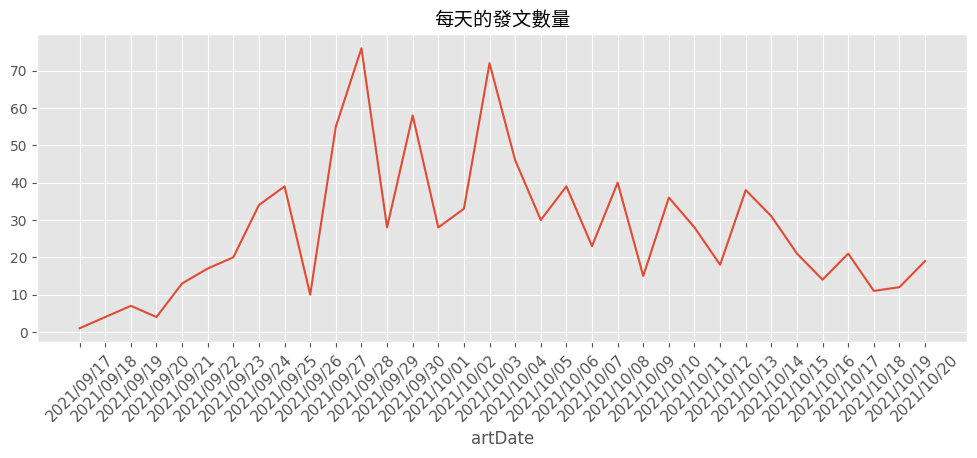

In [535]:
data_datecount = pd.DataFrame(MetaData.groupby('artDate').size(),columns = ['count'])

plt.figure(figsize=(12,4))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.title('每天的發文數量', fontproperties=font_prop)
plt.xlabel('artDate')
plt.xticks(rotation= 45, fontsize=11)
plt.plot(data_datecount.index,data_datecount['count'].tolist())

### 3.3 正負向情緒分數聲量折線圖圖
分別畫出文集中，正向（positive）與負向（negative）情緒的折線圖

In [536]:
#文章和與LIWC情緒字典做合併
data_liwc = pd.merge(data, df_liwc, on=['word'],how='left')

#算出每天情緒總和(sentiment_count)
sentiment_count = data_liwc.groupby(['artDate','sentiments'],as_index=False).size()
sentiment_count.head()

,artDate,sentiments,size
0,2021-09-17,negative,3
1,2021-09-17,positive,3
2,2021-09-18,negative,39
3,2021-09-18,positive,19
4,2021-09-19,negative,25


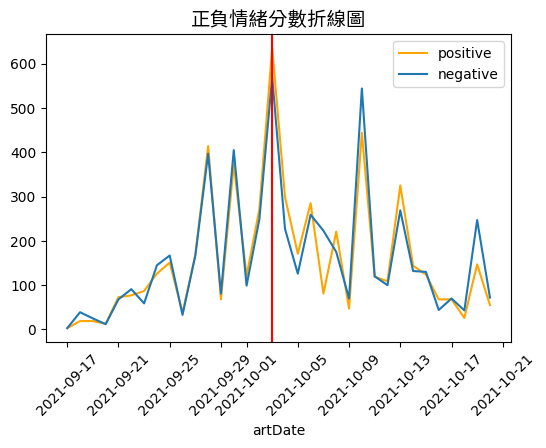

In [537]:
p = sentiment_count[sentiment_count['sentiments']=='positive']
n = sentiment_count[sentiment_count['sentiments']=='negative']

plt.figure(figsize=(6,4))   # 顯示圖框架大小 (寬,高)
plt.style.use("default")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.title('正負情緒分數折線圖', fontproperties=font_prop)
plt.plot(p['artDate'].tolist(), p['size'], label='positive',color="orange")
plt.plot(n['artDate'].tolist(), n['size'], label='negative')
plt.xticks(rotation= 45, fontsize=10)
plt.legend() #顯示圖例
plt.axvline(x=datetime.strptime('2021-10-03', "%Y-%m-%d"), color="red", ls="-")
plt.xlabel('artDate')
plt.show()

畫出每天的情緒總分數，每天的正反情緒差不多，大約在10/03左右達到高峰。

### 3.4 正負向情緒分數比例折線圖圖

In [538]:
# 計算，情緒分數比例
sentiment_count_r = sentiment_count.assign(ratio = sentiment_count.groupby(['artDate'], as_index=False)
                                           .apply(lambda x: x['size'] / sum(x['size'])).reset_index(level=0, drop=True))

# 計算，除了「遊戲」以外的情緒分數比例
sentiment_count_without_r = sentiment_count_without.assign(ratio = sentiment_count_without.groupby(['artDate'], as_index=False)
                                           .apply(lambda x: x['size'] / sum(x['size'])).reset_index(level=0, drop=True))

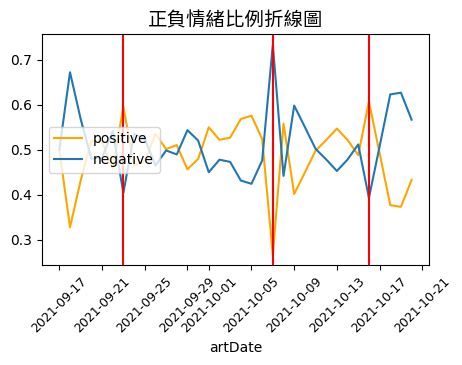

In [539]:
sentiment_count_r = sentiment_count_r[sentiment_count_r['artDate'] > '2021/03/13']
p = sentiment_count_r[sentiment_count_r['sentiments']=='positive']
n = sentiment_count_r[sentiment_count_r['sentiments']=='negative']

plt.figure(figsize=(5,3))   # 顯示圖框架大小 (寬,高)
plt.style.use("default")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.title('正負情緒比例折線圖', fontproperties=font_prop)
plt.plot(p['artDate'].tolist(), p['ratio'], label='positive',color="orange")
plt.plot(n['artDate'].tolist(), n['ratio'], label='negative')
plt.xticks(rotation= 45, fontsize=9)
plt.legend(loc='center left') #顯示圖例
plt.axvline(x=datetime.strptime('2021-09-23', "%Y-%m-%d"), color="red", ls="-") # 正面多
plt.axvline(x=datetime.strptime('2021-10-07', "%Y-%m-%d"), color="red", ls="-") # 負面多
plt.axvline(x=datetime.strptime('2021-10-16', "%Y-%m-%d"), color="red", ls="-") # 正面多
plt.xlabel('artDate')
plt.show()

透過上圖我們可以發現09/23、10/16正面情緒較多；10/07、10/19負面情緒較多。

### 3.5 文字雲
針對不同日期畫出該天的文字雲，如果文字雲中的字詞大小越大，代表出現頻率越高

In [540]:
def Wc_dict(df, Date, countB, countS):
    wc_df = (df.query('artDate == @Date') # 篩選日期
             .query('size < @countB')# 篩選最大數量
             .query('size > @countS')# 篩選最小數量
             .sort_values('size', ascending=False))
    wc_dict = dict(zip(wc_df['word'], wc_df['size'])) #建立成dictionary
    
    return wc_dict
    

### 2021-09-23 文字雲 (正面多)
2021-09-23的文字雲，這天正面情緒較高，發現此時負面批評詞彙較少，出現較多的詞，如「笑死」、「真的」，推測此時網友討論劇情應是較為有趣的內容。

In [541]:
dict_0923 = Wc_dict(word_count,"2021-09-23", 500, 0)

# 印出前 10 字詞
pd.DataFrame(list(dict_0923.items()), columns=['Date', 'DateValue']).head(10)

,Date,DateValue
0,魷魚遊戲,34
1,笑死,32
2,真的,20
3,台灣,17
4,號碼,12
5,老人,12
6,電話,12
7,無聊,11
8,一堆,11
9,日本,9


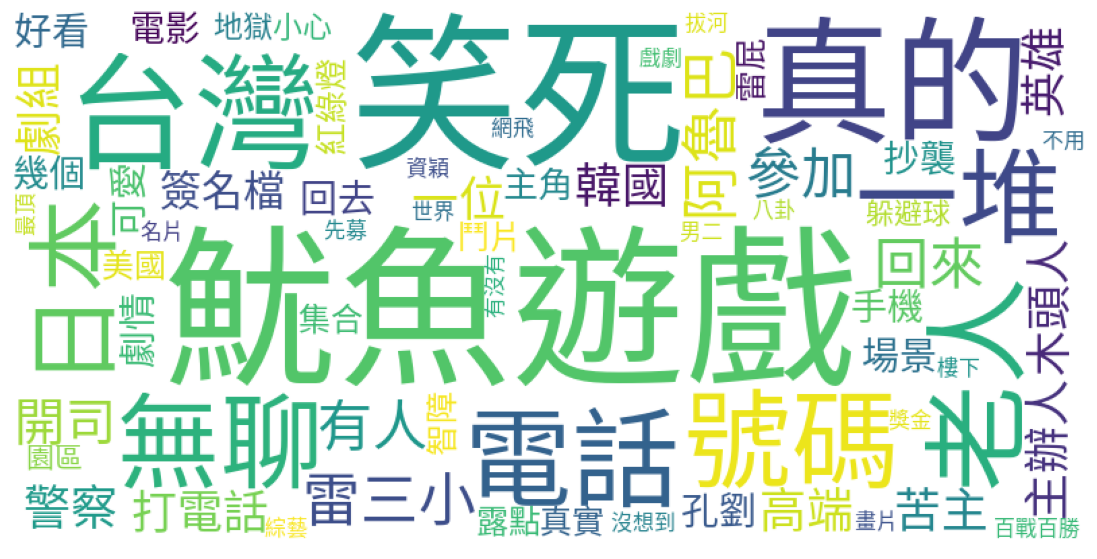

In [542]:
font = path.join(project_path, 'SourceHanSansTW-Regular.otf') #中文字型路徑
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict_0923)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

### 2021-10-07 文字雲(負面多)
先從2021-10-07的情緒高點看起，呼應上面負面的情緒分析，出現了「詐欺」造成很多負面分數，而這個討論則是因為劇情內容，融合《詐欺遊戲》和《今際之國的闖關者》的其他影集內容，而網友們對此進行劇情的比較討論。


In [543]:
dict_1007 = Wc_dict(word_count,"2021-10-07",450,0)

# 印出前 10 字詞
pd.DataFrame(list(dict_1007.items()), columns=['Date', 'DateValue']).head(10)

,Date,DateValue
0,詐欺,115
1,賭博,53
2,魷魚遊戲,40
3,台灣,34
4,真的,33
5,中國,30
6,今際,29
7,韓國,26
8,漫畫,19
9,好看,19


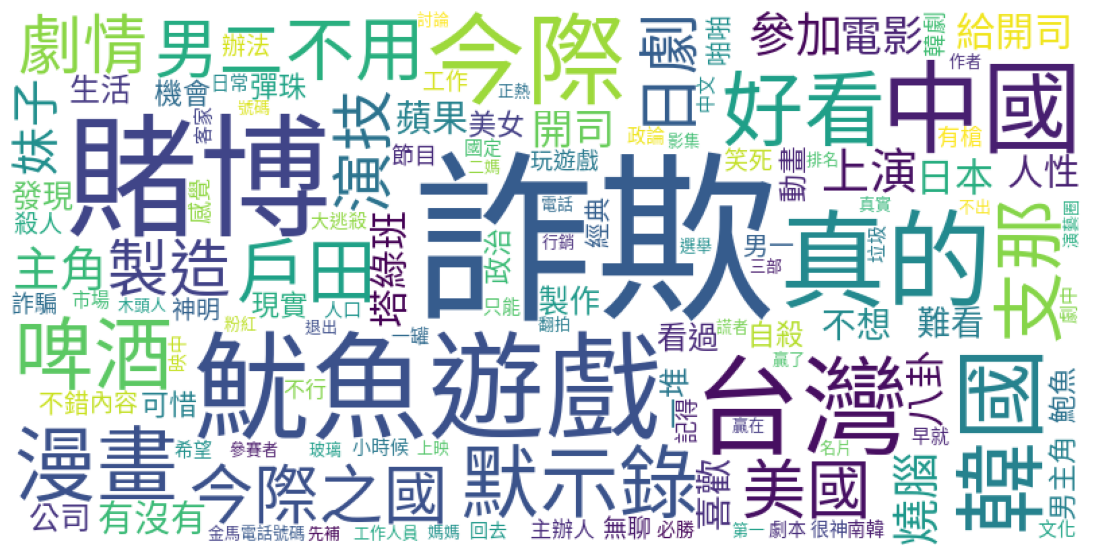

In [544]:
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict_1007)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

### 2021-10-16 文字雲 (正面多)
2021-03-21的文字雲，這裡正反情緒差不多，出現最多字詞為「賭博」，是因網友討論劇情內容疑似抄襲《賭博默示錄》，另外「玻璃」則是因為劇情內出現強化玻璃打造的橋。

In [545]:
dict_1016 = Wc_dict(word_count,"2021-10-16",500,0)

# 印出前 10 字詞
pd.DataFrame(list(dict_1016.items()), columns=['Date', 'DateValue']).head(10)

,Date,DateValue
0,賭博,24
1,魷魚遊戲,23
2,玻璃,20
3,正妹,18
4,默示錄,16
5,韓國,13
6,日本,11
7,真的,11
8,開司,11
9,動腦,9


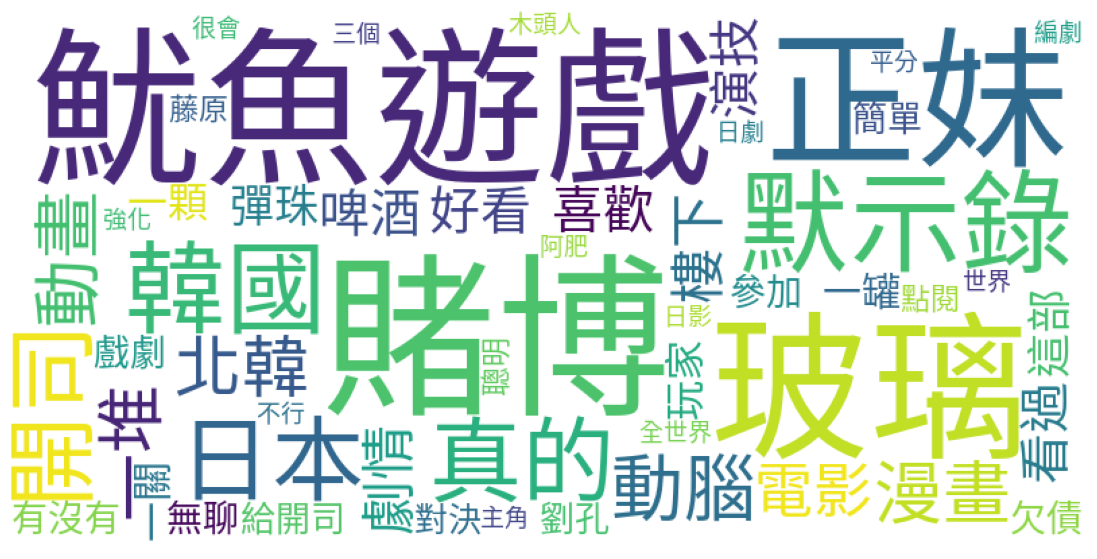

In [546]:
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict_1016)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

### 3.6 情緒代表字
從整個文集中計算出正負向情緒字的出現詞頻，並找出情緒的代表字

In [547]:
sentiment_sum = (word_count.merge(df_liwc, on='word')
                 .groupby(['word', 'sentiments'], as_index=False)
                 .agg({'size': 'sum'}))
sentiment_sum = sentiment_sum.sort_values(by=['size'], ascending=False)  #排序
sentiment_sum.head()

,word,sentiments,size
121,笑死,positive,441
145,難看,negative,369
3,不錯,positive,320
134,詐欺,negative,289
21,八卦,negative,281


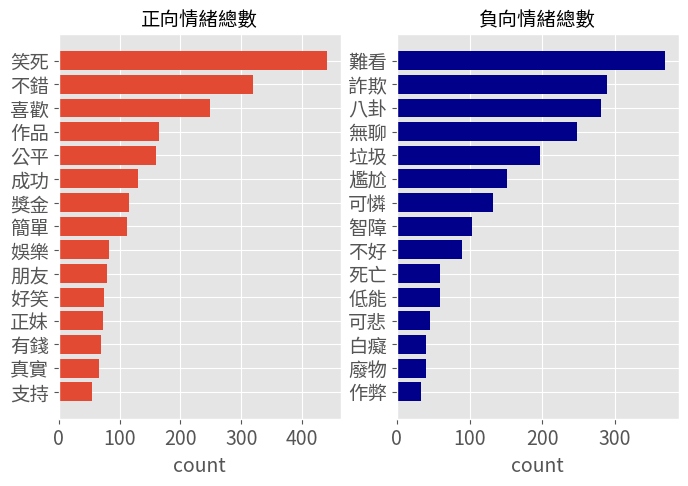

In [548]:
p_sum = sentiment_sum[sentiment_sum["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = sentiment_sum[sentiment_sum["sentiments"]=="negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('正向情緒總數', fontproperties=font_prop)
plt.xlabel('count', fontproperties=font_prop)
plt.barh(p_sum['word'],p_sum['size'])

plt.xticks(fontproperties=font_prop)
plt.yticks(fontproperties=font_prop)

plt.subplot(122)
plt.title('負向情緒總數', fontproperties=font_prop)
plt.xlabel('count', fontproperties=font_prop)
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")

plt.xticks(fontproperties=font_prop)
plt.yticks(fontproperties=font_prop)
plt.show()

另外，也可以依據不同日期觀察情緒代表字的變化
### 2021-10-07 正負情緒代表字

In [549]:
sentiment_date_sum = (word_count.merge(df_liwc, on='word')
                 .groupby(['artDate', 'word', 'sentiments'], as_index=False)
                 .agg({'size': 'sum'}))

#篩選日期
sentiment_1007 = sentiment_date_sum[sentiment_date_sum['artDate']=="2021-10-07"].sort_values(by=['size'], ascending=False)
sentiment_1007.head()

,artDate,word,sentiments,size
413,2021-10-07,詐欺,negative,115
406,2021-10-07,八卦,negative,9
407,2021-10-07,喜歡,positive,8
415,2021-10-07,難看,negative,8
405,2021-10-07,不錯,positive,5


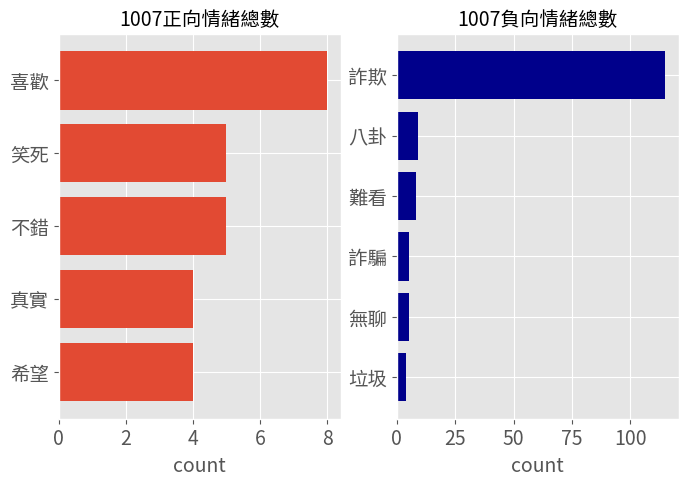

In [550]:
p_sum = sentiment_1007[sentiment_1007["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = sentiment_1007[sentiment_1007["sentiments"]=="negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('1007正向情緒總數', fontproperties=font_prop)
plt.xlabel('count', fontproperties=font_prop)
plt.barh(p_sum['word'],p_sum['size'])

plt.xticks(fontproperties=font_prop)
plt.yticks(fontproperties=font_prop)

plt.subplot(122)
plt.title('1007負向情緒總數', fontproperties=font_prop)
plt.xlabel('count', fontproperties=font_prop)
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")

plt.xticks(fontproperties=font_prop)
plt.yticks(fontproperties=font_prop)

plt.show()

### 2021-10-16 正負情緒代表字

In [551]:
#篩選日期
sentiment_1016 = sentiment_date_sum[sentiment_date_sum['artDate']=="2021-10-16"].sort_values(by=['size'], ascending=False)
sentiment_1016.head()

,artDate,word,sentiments,size
588,2021-10-16,正妹,positive,18
586,2021-10-16,喜歡,positive,6
587,2021-10-16,欠債,negative,5
589,2021-10-16,無聊,negative,5
590,2021-10-16,簡單,positive,5


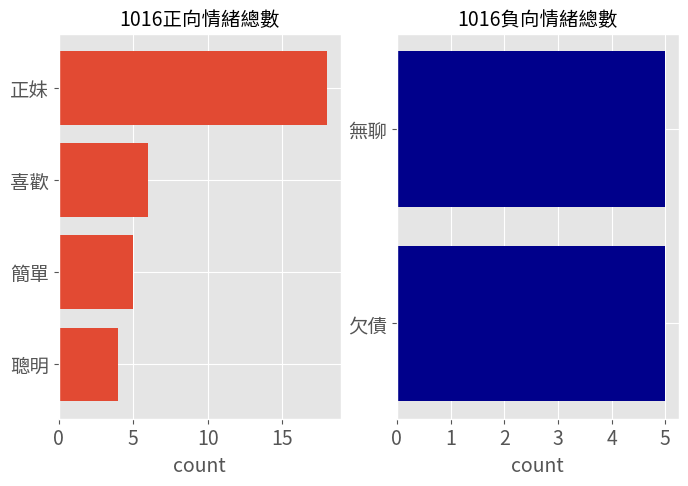

In [552]:
p_sum = sentiment_1016[sentiment_1016["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = sentiment_1016[sentiment_1016["sentiments"]=="negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('1016正向情緒總數', fontproperties=font_prop)
plt.xlabel('count', fontproperties=font_prop)
plt.barh(p_sum['word'],p_sum['size'])

plt.xticks(fontproperties=font_prop)
plt.yticks(fontproperties=font_prop)

plt.subplot(122)
plt.title('1016負向情緒總數', fontproperties=font_prop)
plt.xlabel('count', fontproperties=font_prop)
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")

plt.xticks(fontproperties=font_prop)
plt.yticks(fontproperties=font_prop)

plt.show()

比較10/07和10/16的正負情緒代表字。  
- 在正面情緒部分 10/07 可以看到比較多「喜歡」、「笑死」、「不錯」等詞，可以看出當時網友在討論劇情很好笑
- 10/07 負面情緒則是因討論類似的影集《詐欺遊戲》。

- 而 10/16 有較多「正妹」、「喜歡」等詞，應該是當時有一則新聞「北捷《魷魚》正妹找到了」大意是有正妹穿著劇內同款衣服搭捷運。


### 3.7 歸類正負面文章
- 之前的情緒分析大部分是全部的詞彙加總，接下來將正負面情緒的文章分開，看看能不能發現一些新的東西。 
 
- 接下來歸類文章，將每一篇文章正負面情緒的分數算出來，然後大概分類文章屬於正面還是負面。

In [553]:
article_type = (data.merge(df_liwc, on='word')
                .groupby(['artUrl', 'sentiments'], as_index=False)
                .size()
                .pivot_table(index='artUrl', columns='sentiments', values='size', fill_value=0)
                .reset_index(['artUrl'])
               )
article_type.head()

sentiments,artUrl,negative,positive
0,https://www.ptt.cc/bbs/Gossiping/M.1631884426.A.ED3.html,3,3
1,https://www.ptt.cc/bbs/Gossiping/M.1631986044.A.A57.html,14,11
2,https://www.ptt.cc/bbs/Gossiping/M.1631988940.A.B82.html,6,2
3,https://www.ptt.cc/bbs/Gossiping/M.1631991558.A.AEB.html,6,1
4,https://www.ptt.cc/bbs/Gossiping/M.1632004934.A.936.html,13,5


In [554]:
article_type['type'] = article_type.apply(lambda x: 'positive' if x['positive'] > x['negative'] else 'negative',axis=1)
article_type.groupby('type', as_index=False).size()

,type,size
0,negative,523
1,positive,365


### 正負情緒文章數量統計圖

In [555]:
article_type_date = article_type.merge(MetaData.loc[:,["artUrl", "artDate"]], how = 'left', on = 'artUrl')
article_type_date = article_type_date.groupby(['artDate','type'], as_index=False).size()
#article_type_date

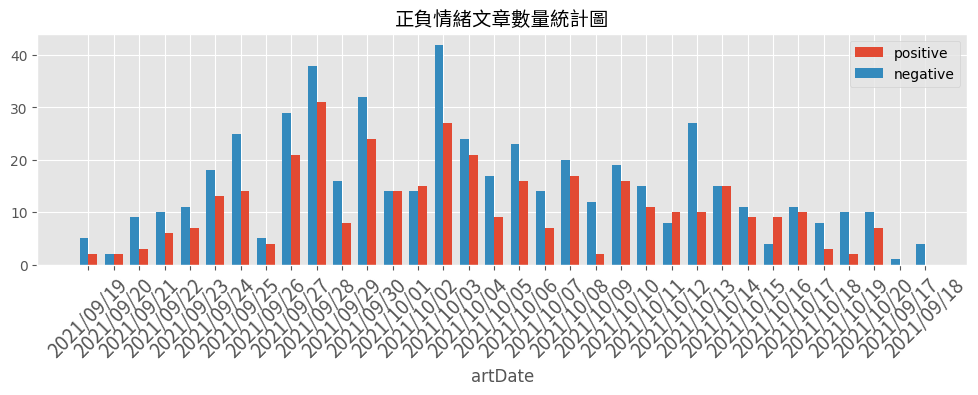

In [556]:
ap = article_type_date[(article_type_date["type"]=="positive")&(article_type_date["artDate"]>="2021/09/01")&(article_type_date["artDate"]<="2021/11/01")]
an = article_type_date[(article_type_date["type"]=="negative")&(article_type_date["artDate"]>="2021/09/01")&(article_type_date["artDate"]<="2021/11/01")]

plt.figure(figsize=(12,3))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.title('正負情緒文章數量統計圖', fontproperties=font_prop)
plt.xlabel('artDate')
plt.bar(ap['artDate'],ap['size'],align="edge",width=0.35,label="positive")
plt.bar(an['artDate'],an['size'],align="edge",width=-0.35,label="negative")
plt.legend()
plt.xticks(rotation= 45, fontsize=5, fontproperties=font_prop)
plt.xlabel('artDate')

plt.show()

### 3.8 情緒關鍵字
把正面和負面的文章挑出來，並和斷詞結果合併

In [557]:
positive_article = article_type[article_type["type"]=="positive"].merge(data, how = 'left', on = 'artUrl')
negative_article = article_type[article_type["type"]=="negative"].merge(data, how = 'left', on = 'artUrl')

### 情緒關鍵字:負面情緒文章

In [558]:
negative_article = (negative_article.merge(df_liwc, on='word')
                    .groupby(['word', 'sentiments'], as_index=False)
                    .size()
                    .sort_values('size', ascending = False))

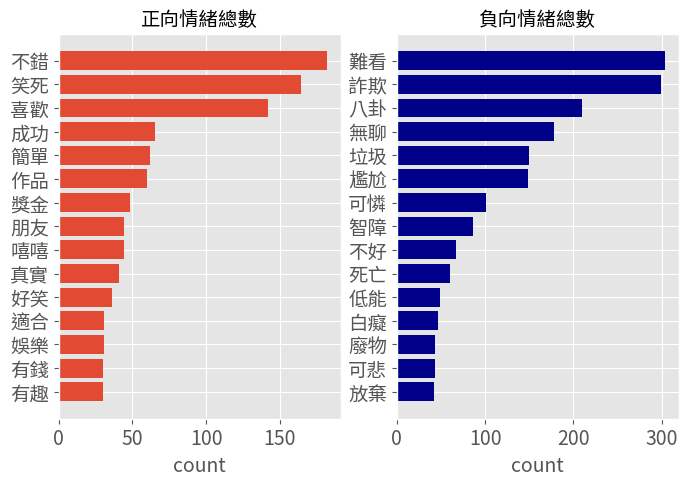

In [559]:
p_sum = negative_article[negative_article["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = negative_article[negative_article["sentiments"]=="negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('正向情緒總數', fontproperties=font_prop)
plt.xlabel('count', fontproperties=font_prop)
plt.barh(p_sum['word'],p_sum['size'])

plt.xticks(fontproperties=font_prop)
plt.yticks(fontproperties=font_prop)

plt.subplot(122)
plt.title('負向情緒總數', fontproperties=font_prop)
plt.xlabel('count', fontproperties=font_prop)
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")

plt.xticks(fontproperties=font_prop)
plt.yticks(fontproperties=font_prop)


plt.show()

### 情緒關鍵字:正面情緒文章

In [560]:
positive_article = (positive_article.merge(df_liwc, on='word')
                    .groupby(['word', 'sentiments'], as_index=False)
                    .size()
                    .sort_values('size', ascending = False))

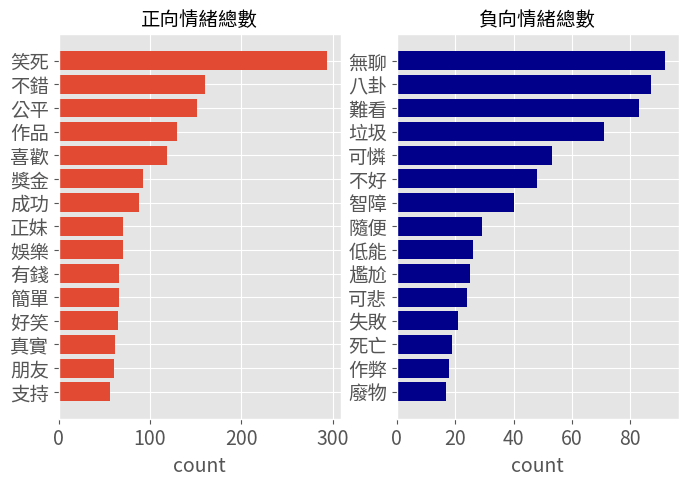

In [561]:
p_sum = positive_article[positive_article["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = positive_article[positive_article["sentiments"]=="negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('正向情緒總數', fontproperties=font_prop)
plt.xlabel('count', fontproperties=font_prop)
plt.barh(p_sum['word'],p_sum['size'])

plt.xticks(fontproperties=font_prop)
plt.yticks(fontproperties=font_prop)

plt.subplot(122)
plt.title('負向情緒總數', fontproperties=font_prop)
plt.xlabel('count', fontproperties=font_prop)
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")

plt.xticks(fontproperties=font_prop)
plt.yticks(fontproperties=font_prop)


plt.show()

從正負面情緒圖觀察發現，正面和負面的關鍵字沒有甚麼顯著的差異。

### 3.9 解讀有興趣的關鍵字
關「塔綠班」什麼事？
在 10/02 出現頻繁的關鍵字「塔綠班」

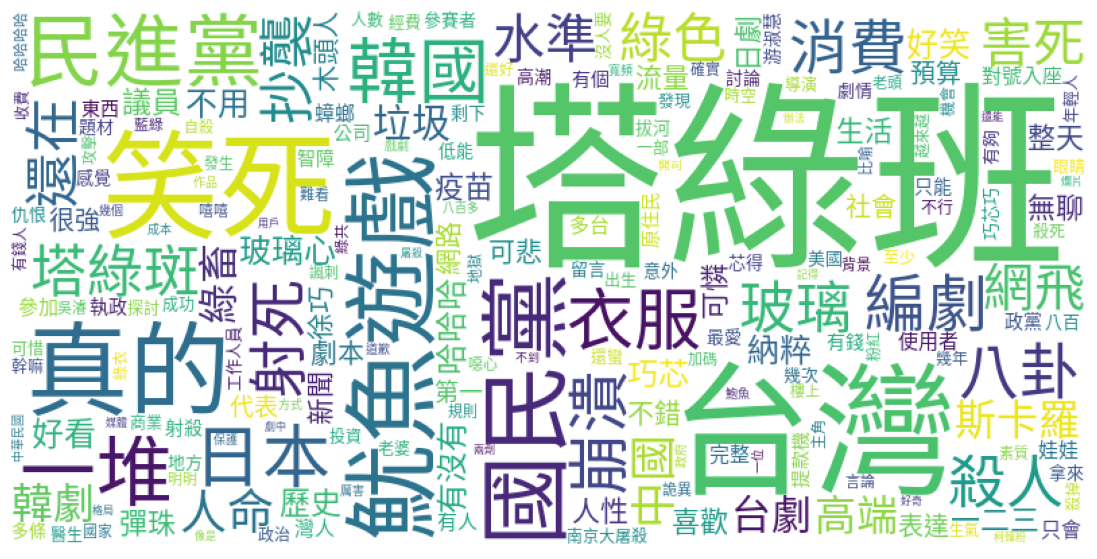

In [562]:
dict_1002 = Wc_dict(word_count,"2021-10-02",500,0)

wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict_1002)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

In [563]:
# 印出前 10 字詞
talvban_df = pd.DataFrame(list(dict_1002.items()), columns=['Date', 'DateValue'])
talvban_df.head(10)

,Date,DateValue
0,塔綠班,324
1,台灣,142
2,笑死,90
3,真的,68
4,魷魚遊戲,60
5,國民黨,53
6,民進黨,39
7,一堆,37
8,韓國,32
9,日本,29


In [564]:
word_count[word_count['word'] == "塔綠班"].head()

,artDate,word,size
25906,2021-10-02,塔綠班,324
29691,2021-10-03,塔綠班,136
41108,2021-10-06,塔綠班,26
69988,2021-10-19,塔綠班,23
38719,2021-10-05,塔綠班,23


In [565]:
talvban = data[(data['artDate'] == "2021-10-02") & (data['word'] == "塔綠班")].drop_duplicates(subset="artUrl", keep="last")

pd.set_option('display.max_colwidth', None)
MetaData[MetaData['artUrl'].isin(talvban['artUrl'])][['artTitle','sentence', 'word']]

,artTitle,sentence,word
399,[新聞]女議員撞臉《魷魚》詭異娃娃 徐巧芯認證,媒體來源記者署名蔡文鈴完整新聞標題女議員撞臉魷魚詭異娃娃徐巧芯認證她射死一堆穿綠衣服的完整新聞內文韓劇魷魚遊戲熱播中劇中的各種角色引發不少話題其中有一名網友發現劇中首登場遊戲木頭人的詭異娃娃神似國民黨台北市議員游淑慧甚至獲得同黨游淑慧日晚間在臉書發文表示有網友說她很像魷魚遊戲中的詭異娃娃但她看不出哪裡像結果同黨議員鍾佩君說有像耶游淑慧說只有自己後知後覺凝視詭異娃娃的圖片秒後疑惑是圓嘟嘟像還是眼神殺像貼文一出後還說游淑慧則回覆那我努力兩人對話讓許多網友笑翻有網友留言用眼神殺塔綠班不說不像說了就像完整新聞連結或短網址備註,"[媒體, 來源, 署名, 蔡文鈴, 完整, 新聞標題, 女議員, 詭異, 娃娃, 徐巧, 認證, 射死, 一堆, 衣服, 完整, 新聞, 內文, 韓劇, 魷魚遊戲, 熱播, 劇中, 角色, 引發, 話題, 一名, 網友, 發現, 劇中, 登場, 木頭人, 詭異, 娃娃, 神似, 國民黨, 台北市, 議員, 游淑慧, 同黨, 游淑慧日, 晚間, 臉書, 發文, 網友, 魷魚遊戲, 詭異, 娃娃, 看不出, 同黨, 議員, 佩君, 耶游淑慧, 後知後覺, 凝視, 詭異, 娃娃, 圖片, 疑惑, 是圓, 嘟嘟, 眼神, 貼文, 一出, 還說, 游淑慧則, 回覆, 努力, 兩人, 對話, 網友, 網友, 留言, 眼神, 塔綠班, 完整, 新聞, 連結, 網址, 備註]"
403,[問卦]有沒有魷魚遊戲還要玩多久的八卦?,肥宅失業透最近一直被魷魚洗臉不管是新聞還是臉書或事滿滿的都是魷魚遊戲最扯的是魷魚遊戲的彩蛋至少有十二個以上的都在講彩蛋啊我假如是油土伯是不是把這幾個彩蛋集合再拍隻片終極彩蛋大合輯一定流量賺爆有沒有魷魚遊戲還要玩多久的八卦推鮑魚遊戲感覺像是日本某神秘公司會拍的主題像是全員逃跑中就有拍過惡搞又實用不過模仿對象是韓國恐怕很難了,"[肥宅, 失業, 洗臉, 新聞, 臉書, 滿滿的, 魷魚遊戲, 最扯, 魷魚遊戲, 彩蛋, 至少, 十二個, 在講, 彩蛋, 油土伯, 幾個, 彩蛋, 集合, 終極, 彩蛋, 大合輯, 流量, 有沒有, 魷魚遊戲, 多久, 八卦, 鮑魚, 感覺, 像是, 日本, 神秘, 公司, 主題, 像是, 全員, 逃跑, 拍過, 惡搞, 實用, 模仿, 對象, 韓國, 很難]"
411,[問卦]身價多少的富豪才能經營的起魷魚遊戲？,如題就是這陣子蠻紅的影劇魷魚遊戲啦我是覺得還不錯看的好奇要身價多少的富豪才經營得起這個遊戲啊首先從參加者來看最新年度的參賽者有位也就是億韓圜大概億台幣左右買下一座與世隔絕無人島的錢對所有潛在參賽者的身家調查與小時監控不被外界發現下把每一批參賽者運到島上的花費島上的各種大型遊戲設施以及負責運作與善後的數百位忠貞的工作人員,"[這陣子, 蠻紅, 影劇, 魷魚遊戲, 不錯, 好奇, 身價, 富豪, 經營, 參加者, 最新, 年度, 參賽者, 有位, 億韓, 億台幣, 買下, 一座, 與世隔絕, 無人島, 潛在, 參賽者, 身家, 調查, 小時, 監控, 外界, 發現, 一批, 參賽者, 運到, 島上, 花費, 島上, 大型, 設施, 負責, 運作, 善後, 數百位, 忠貞, 工作人員]"
416,[新聞]徐巧芯讚《魷魚》娃娃射死綠衣服的 吳濬彥：她示範何謂喪心病狂,媒體來源記者署名張鈞量完整新聞標題徐巧芯讚魷魚娃娃射死綠衣服的吳濬彥她示範何謂喪心病狂完整新聞內文國民黨台北市議員游淑慧日前被指神似韓劇魷魚遊戲中射殺參賽者的詭異娃娃玩偶國民黨北市議員徐巧芯還開玩笑表示游淑慧真的射死一堆穿綠衣服的人這說法引起民進黨不滿民進黨前發言人吳濬彥日批評並諷刺地以納粹射殺猶太人來比喻國民黨吳濬彥諷刺你能不能想像年的今天有任何一個帶有納粹背景的議員說出很強射死一堆穿戴小圓頂帽的人如果你不能想像徐巧芯就示範給你看何謂喪心病狂吳濬彥表示作為一個台北市議員徐巧芯戲謔的在游淑慧跟風魷魚遊戲的某一貼文留言處留言塔綠班去呼應該戲劇之劇情也在另一留言處說戲裡第一個遊戲關卡木頭人裡的機關很強射死很多綠衣服的人吳濬彥批評徐巧芯可能忘了在年時其所屬政黨國民黨就確實真的發起大規模的全島武裝鎮壓掃射殺死許多台灣人並展開長達年白色恐怖統治無數人民家破人亡使台灣社會生活在恐懼之中他表示我們能忍受納粹嗎我們不能我們不能又如何能忍受國民黨呢完整新聞連結或短網址,"[媒體, 來源, 署名, 張鈞量, 完整, 新聞標題, 徐巧, 娃娃, 射死, 衣服, 吳濬, 示範, 何謂, 喪心病狂, 完整, 新聞, 內文, 國民黨, 台北市, 議員, 游淑慧, 日前, 神似, 韓劇, 魷魚遊戲, 射殺, 參賽者, 詭異, 娃娃, 玩偶, 國民黨, 市議員, 徐巧, 芯還, 開玩笑, 游淑慧, 真的, 射死, 一堆, 衣服, 說法, 民進黨, 民進黨, 發言人, 吳濬, 彥日, 批評, 諷刺, 地以, 納粹, 射殺, 猶太人, 比喻, 國民黨, 吳濬, 諷刺, 想像, 帶有, 納粹, 背景, 議員, 說出, 很強, 射死, 一堆, 穿戴, 圓頂, 想像, 徐巧, 示範, 給你看, 何謂, 喪心病狂, 吳濬, 台北市, 議員, 徐巧, 戲謔, 游淑慧, 跟風, 魷魚遊戲, 貼文, 留言, 留言, 塔綠班, 戲劇, 劇情, 留言, 處說, 戲裡, 第一個, 關卡, 木頭人, 裡的, 機關, 很強, 射死, 衣服, 吳濬, 批評, ...]"
423,[問卦]魷魚遊戲預算4.7億相同錢台灣能拍同等級,查了一下魷魚遊戲的拍片經費是億如果台劇也有相同經費去拍個集我想可能不一定會輸魷魚遊戲首先有這樣經費就可以請國外團隊來幫忙再來是台灣編劇很強甚至可以寫出比今際之國更好的劇本無論是改編還是原創要寫這樣生存遊戲的題材又可以有很多戲劇借鏡至於演員方面精挑細選應該不會太差還可以找一些外國人來演比方來個多個國家人一起玩的台版魷魚遊戲頂多就是不是韓劇在全球不香但多不定在亞洲可以獲得很高的支持度吧只要把亞洲當紅演員也找來演就行了大家覺得給台劇億拍集類似魷魚遊戲的台劇是否也可以不輸魷魚遊戲的水準呢,"[魷魚遊戲, 拍片, 經費, 台劇, 經費, 拍個, 會輸, 魷魚遊戲, 經費, 國外, 團隊, 幫忙, 再來, 台灣, 編劇, 很強, 寫出, 今際之國, 更好, 劇本, 無論是, 改編, 原創, 生存, 題材, 戲劇, 借鏡, 演員, 精挑細選, 太差, 外國人, 來演, 來個, 多個, 國家, 台版, 魷魚遊戲, 韓劇, 全球, 不香, 亞洲, 支持, 亞洲, 當紅, 演員, 找來, 就行了, 給台劇, 拍集, 類似, 魷魚遊戲, 台劇, 不輸, 魷魚遊戲, 水準]"


#### [新聞]女議員撞臉《魷魚》詭異娃娃　徐巧芯認證
原來是有民進黨議員撞臉劇內的一個角色

![詭異娃娃](https://cc.tvbs.com.tw/img/upload/2021/10/13/20211013105331-a4786155.jpg)